In [1]:
# This example is inspired from 

In [5]:
#from fastai import *
from fastai.text import *
#from fastai.datasets import *
#from pathlib import Path

In [6]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.0.dev20190320


In [7]:
#path = untar_data("http://files.fast.ai/data/examples/imdb_sample.tgz",dest=DATA_PATH)
#path = untar_data(URLs.IMDB)
path = Path('/home/dell/.fastai/data/imdb/')
path.ls()

[PosixPath('/home/dell/.fastai/data/imdb/trained_model.pth'),
 PosixPath('/home/dell/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/dell/.fastai/data/imdb/models'),
 PosixPath('/home/dell/.fastai/data/imdb/README'),
 PosixPath('/home/dell/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/dell/.fastai/data/imdb/unsup'),
 PosixPath('/home/dell/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/dell/.fastai/data/imdb/train'),
 PosixPath('/home/dell/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/dell/.fastai/data/imdb/test'),
 PosixPath('/home/dell/.fastai/data/imdb/tmp_lm')]

In [8]:
dataProcess = False
modelTrain = True
bs = 48

In [7]:
'''if dataProcess:
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=64)
    data_lm.save('data_lm_export.pkl')
    data_clas.save('data_clas_export.pkl')
else:
    data_lm = load_data(path, fname='data_lm_export.pkl', bs=16)
    data_clas = load_data(path, fname='data_clas_export.pkl', bs=16)
'''

In [10]:
if dataProcess:
    data_lm = (TextList.from_folder(path)
               #Inputs: all the text files in path
                .filter_by_folder(include=['train', 'test', 'unsup'])
               #We may have other temp folders that contain text files so we only keep what's in train and test
                .random_split_by_pct(0.1)
               #We randomly split and keep 10% (10,000 reviews) for validation
                .label_for_lm()           
               #We want to do a language model so we label accordingly
                .databunch(bs=bs))

    data_lm.save('data_lm.pkl')


    data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
                 #grab all the text files in path
                 .split_by_folder(valid='test')
                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
                 .label_from_folder(classes=['neg', 'pos'])
                 #label them all with their folders
                 .databunch(bs=bs))

    data_clas.save('data_clas.pkl')

else:
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    data_clas = load_data(path, 'data_clas.pkl', bs=bs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


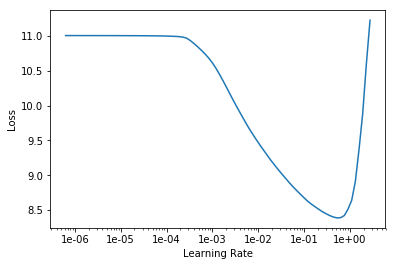

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.lr_find()
learn.recorder.plot()

In [27]:
preTrainedWt103Path = Path('/home/dell/Code/fastai_examples/data/models/wt103_v1/')
#! wget -nH -r -np -P {preTrainedWt103Path} http://files.fast.ai/models/wt103_v1/

In [28]:
if modelTrain:
    learn.load_pretrained(wgts_fname = preTrainedWt103Path/'lstm_wt103.pth', itos_fname = preTrainedWt103Path/'itos_wt103.pkl', strict=False )  
    learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
    pathModel = learn.save(path/"trained_model")
else:
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
    learn.load(path/"trained_model")

epoch,train_loss,valid_loss,accuracy,time
1,4.078839,3.938386,0.310942,26:14


In [29]:
learn.save('fit_head')

In [40]:
learn.load('fit_head');

In [41]:
learn.unfreeze()

In [42]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.953902,3.879575,0.316759,26:16


In [43]:
learn.save('fine_tuned')

In [44]:
learn.load('fine_tuned');

In [82]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [83]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

TypeError: predict() takes 2 positional arguments but 3 were given

In [47]:
learn.save_encoder('ft_enc')

In [48]:
torch.cuda.empty_cache()

In [13]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,pretrained=True)
learn.load_encoder('ft_enc')

In [49]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,0.334005,0.252525,0.898240,03:53
2,0.320792,0.244180,0.901960,04:06
3,0.310386,0.231587,0.909680,03:59


In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


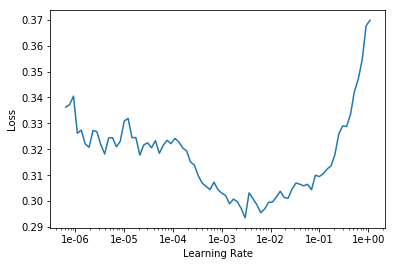

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.309247,0.236653,0.906440,04:09


In [53]:
learn.save('first')

In [54]:
learn.load('first');

In [55]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.282073,0.205093,0.920080,04:16


In [56]:
learn.save('second')

In [57]:
learn.load('second');

In [58]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.242669,0.192156,0.924440,06:04


In [59]:
learn.save('third')

In [60]:
learn.load('third');

In [61]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.234738,0.189350,0.925600,06:56
2,0.221414,0.188592,0.926880,06:57


In [63]:
learn.save('final')

In [14]:
learn.load('final');

Language modeling accuracy is generally measured using the metric perplexity, which is simply exp() of the loss function we used.

The cross-entropy of two probability distributions P and Q tells us the minimum average number of bits we need to encode events of P, when we develop a coding scheme based on Q. So, P is the true distribution, which we usually don't know. We want to find a Q as close to P as possible, so that we can develop a nice coding scheme with as few bits per event as possible.

I shouldn't say bits, because we can only use bits as a measure if we use base 2 in the calculation of the cross-entropy. But TensorFlow uses the natural logarithm, so instead let's measure the cross-entropy in nats.

So let's say we have a bad language model that says every token (character / word) in the vocabulary is equally probable to be the next one. For a vocabulary of 1000 tokens, this model will have a cross-entropy of log(1000) = 6.9 nats. When predicting the next token, it has to choose uniformly between 1000 tokens at each step.

A better language model will determine a probability distribution Q that is closer to P. Thus, the cross-entropy is lower - we might get a cross-entropy of 3.9 nats. If we now want to measure the perplexity, we simply exponentiate the cross-entropy:

exp(3.9) = 49.4

So, on the samples, for which we calculated the loss, the good model was as perplex as if it had to choose uniformly and independently among roughly 50 tokens.

In [12]:
math.exp(3.9)

49.40244910553017

Now let's try to calculate similarites for sentences

In [15]:
x_inp = ["i like apples",
         "i want to buy some apples",
         "where is your cell phone",
        "buy me some apples"]

In [16]:
x_inp2 = ["king",
         "man",
          "woman",
         "queen"
         ]

In [29]:
inputs = x_inp

In [30]:
import multiprocessing
n_cpu = multiprocessing.cpu_count()

In [31]:
tok = Tokenizer().process_all(partition_by_cores(inputs,n_cpu-1))
tok

[['[', "'", 'i', 'like', 'apples', "'", ']'],
 ['[', "'", 'i', 'want', 'to', 'buy', 'some', 'apples', "'", ']'],
 ['[', "'", 'where', 'is', 'your', 'cell', 'phone', "'", ']'],
 ['[', "'", 'buy', 'me', 'some', 'apples', "'", ']']]

In [32]:
import re 

#to calculate a accurate similarity special tokens will be excluded

filteredTokens = []
for tokenizedWord in tok:
    filteredToken = [token for token in tokenizedWord if not re.search('xx',token)]
    filteredTokens.append(filteredToken)
filteredTokens

[['[', "'", 'i', 'like', 'apples', "'", ']'],
 ['[', "'", 'i', 'want', 'to', 'buy', 'some', 'apples', "'", ']'],
 ['[', "'", 'where', 'is', 'your', 'cell', 'phone', "'", ']'],
 ['[', "'", 'buy', 'me', 'some', 'apples', "'", ']']]

In [33]:
X = [[data_lm.vocab.stoi[o1] for o1 in o ] for o in filteredTokens]; X 

[[3976, 62, 18, 53, 12821, 62, 3856],
 [3976, 62, 18, 204, 14, 811, 65, 12821, 62, 3856],
 [3976, 62, 135, 15, 147, 2767, 1682, 62, 3856],
 [3976, 62, 811, 88, 65, 12821, 62, 3856]]

In [34]:
#to calculate a accurate similarity non vocab words will be excluded
X = [element for element in X if element[2] != 0 ]; X

[[3976, 62, 18, 53, 12821, 62, 3856],
 [3976, 62, 18, 204, 14, 811, 65, 12821, 62, 3856],
 [3976, 62, 135, 15, 147, 2767, 1682, 62, 3856],
 [3976, 62, 811, 88, 65, 12821, 62, 3856]]

We can we visualize  text classifier as three different part, 1 and 2 is backbone and 3 is head.

1- Embedding layer (Convert integer of words to meaningful vectors)
2- 3 Layer LSTM network (Learned from wikitext and language-model)
3- Finallinear layer  network for Prediction

In [35]:
m = learn.model

In [36]:
#inputs = []
embeddings = []    
for sentence in X:
    #resizeLength = len(x_inp4)
    #to calculate a accurate similarity special chars at the begining and ending will be excluded
    sentenceTrimmed= sentence[2:-2]
    resizeLength = len(sentenceTrimmed)
    inputSentence = tensor(sentenceTrimmed).resize_(resizeLength,1)
    # sentence encoding 400 dims. -1 is the last element that's supposed to have the final encoded state
    tmpEmbded = m[0](inputSentence.cuda())
    embeddings.append(tmpEmbded[0][2][0][-1])

In [37]:
def cos_sim(v1,v2):
    return F.cosine_similarity(v1.unsqueeze(0),v2.unsqueeze(0)).mean()

In [38]:
inputs

['i like apples',
 'i want to buy some apples',
 'where is your cell phone',
 'buy me some apples']

In [39]:
range(len(embeddings))

range(0, 4)

In [40]:
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        print(inputs[i] + " with " + inputs[j])
        print(cos_sim(embeddings[i],embeddings[j]).item())

i like apples with i like apples
1.0
i like apples with i want to buy some apples
0.9566953182220459
i like apples with where is your cell phone
0.04804057627916336
i like apples with buy me some apples
-0.08677908033132553
i want to buy some apples with i like apples
0.9566953182220459
i want to buy some apples with i want to buy some apples
0.9999999403953552
i want to buy some apples with where is your cell phone
0.021908557042479515
i want to buy some apples with buy me some apples
-0.08843250572681427
where is your cell phone with i like apples
0.04804057627916336
where is your cell phone with i want to buy some apples
0.021908557042479515
where is your cell phone with where is your cell phone
1.0
where is your cell phone with buy me some apples
0.18760408461093903
buy me some apples with i like apples
-0.08677908033132553
buy me some apples with i want to buy some apples
-0.08843250572681427
buy me some apples with where is your cell phone
0.18760408461093903
buy me some apples w